In [1]:
import pandas as pd
import numpy as np
from functions import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t as student_t   # or your own student_t_pdf

plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 4), 'figure.dpi': 300})

%load_ext autoreload
%autoreload 2

**Table of contents**<a id='toc0_'></a>    
- [Combining data sources](#toc1_)    
    - [Add industry data for DK](#toc1_1_1_)    
    - [Add financial data](#toc1_1_2_)    
    - [Add beta](#toc1_1_3_)    
  - [Add risk-free rate](#toc1_2_)    
- [Create variables](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Combining data sources](#toc0_)

In [2]:
trade = pd.read_csv('data/trade.csv', header=[0,1], index_col=0)
stocks = pd.read_csv('data/stocks.csv')
dk_industry = pd.read_csv('data/dk_industry.csv')
financials = pd.read_csv('data/financials.csv')
# beta = pd.read_csv('data/beta.csv')
rf_rate = pd.read_csv('data/rf_rate.csv')
trade_daily = pd.read_csv('data/trade_daily.csv')

In [3]:
# offsets
quarterly_offset = 3 # quarterly data is 2 months behind end of quarter
annual_offset = 6 # annual data is 6 months behind publication

In [4]:
# convert the index to datetime (the index holds the dates)
trade.index = pd.to_datetime(trade.index)
trade = trade.stack(level=0).reset_index()


# rename columns to have a proper
trade.rename(columns={'level_1': 'ticker'}, inplace=True)

# Data Cleaning and Sorting
trade.drop_duplicates(inplace=True)
trade.dropna(inplace=True) # happens if there was one data point the first day of a given ticker but not the rest of the values (e.g. trade values but no ask or bid)
trade.sort_values(['ticker', 'timestamp'], inplace=True)
trade.reset_index(drop=True, inplace=True)



/var/folders/yw/jsw5n53s1cb1s2q6tt0msrm00000gn/T/ipykernel_70684/3266452105.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  trade = trade.stack(level=0).reset_index()


In [5]:
df = pd.merge(trade, stocks[['ticker','shares','NACE']], how='left', on=['ticker'])
# display(df)


### <a id='toc1_1_1_'></a>[Add industry data for DK](#toc0_)

In [6]:
dk_industry['timestamp'] = pd.to_datetime(dk_industry['timestamp'])
# join stocks and dk_industry on 'NACE industry' 
industry = stocks[['ticker','NACE']].merge(dk_industry, how='left', on='NACE')

# adjust the timestamp to be 2 months behind
industry['timestamp'] = industry['timestamp'] + pd.DateOffset(months=quarterly_offset)
industry['timestamp'] = (
    industry['timestamp']
      .dt.to_period('M')
      .dt.to_timestamp('M')
)

industry = industry.drop(columns=['NACE'])

In [7]:
df = pd.merge(df, industry, how='left', on=['timestamp', 'ticker'])

#ffil the industry values
for col in industry.columns[2:]:
    df[col] = df[col].groupby(df['ticker']).ffill()


### <a id='toc1_1_2_'></a>[Add financial data](#toc0_)

In [8]:
financials['timestamp'] = pd.to_datetime(financials['timestamp'])

financials['timestamp'] = financials['timestamp'] + pd.DateOffset(months=annual_offset)
financials['timestamp'] = (
    financials['timestamp']
      .dt.to_period('M')
      .dt.to_timestamp('M')
)

# expand the dataset
financials = (
    financials
        # sort data and find the next timestamp
      .sort_values(['ticker','timestamp'])
      .assign(
        next_fye   = lambda df: df.groupby('ticker')['timestamp'].shift(-1),
        plus_12m   = lambda df: df['timestamp'] + pd.DateOffset(months=12),
        period_end = lambda df: pd.to_datetime(np.where(
                          (df.next_fye - df.timestamp).abs()
                            < 
                          (df.plus_12m   - df.timestamp).abs(),
                          df.next_fye,
                          df.plus_12m
                        ))
      )
      # expand the data
      .assign(timestamp = lambda df: df.apply(expand_monthly, axis=1))
      .explode('timestamp')
      .drop(columns=['next_fye','plus_12m','period_end'])
      .reset_index(drop=True)
)

# display(financials)

In [9]:
# join df and financials
df = pd.merge(df, financials, how='left', on=['timestamp', 'ticker'])

### <a id='toc1_1_3_'></a>[Add variables calculated on daily data](#toc0_)

In [10]:
trade_daily['timestamp'] = pd.to_datetime(trade_daily['timestamp'])

In [11]:
df.drop(columns=['ask','bid','adjclose','high','low','open','volume','turnover','div'], inplace=True) # drop overlapping columns

In [12]:
# join df and beta
df = pd.merge(df, trade_daily, how='left', on=['timestamp', 'ticker'])

## <a id='toc1_2_'></a>[Add risk-free rate](#toc0_)

In [13]:
rf_rate['timestamp'] = pd.to_datetime(rf_rate['timestamp'])

In [14]:
# join df and beta
df = pd.merge(df, rf_rate, how='left', on=['timestamp'])

# display(df)

# <a id='toc2_'></a>[Feature engineering](#toc0_)

In [15]:
# df['adjclose_div'] = df['adjclose'] + df['div'] # adjcose incl monthly dividend
# df['target'] = df.groupby('ticker')['adjclose_div'].transform(lambda x: x.pct_change(periods=1, fill_method=None))

# # subtract the risk-free rate from the target
# # df['target'] = df['target'] - df['risk_free']
# df['target'] = df['target'].shift(-1) # shift the target by 1 month

df['mcap'] = df['adjclose'] * df['shares'] # market cap

# Green et al features
df['acc'] = (df['netinc'] - df['cashflow'])/df['assets'] # accruals

df['absacc'] = np.abs(df['acc']) # absolute accruals

# df['aeavol'] = None # abnormal earnings announcement volume

df['age'] = (df['timestamp'] - df.groupby('ticker')['timestamp'].transform('min')).dt.days / 365.25 # age of the stock

df['agr'] = (df.groupby('ticker')['assets'].transform(lambda x: x.pct_change(periods=12, fill_method=None))).fillna(0) # yearly asset growth

df['beta'] = df['beta'] # beta

df['betasq'] = df['betasq'] # beta squared

df['bm'] = (df['assets'] - df['liabilities']) / df['mcap'] # book to market ratio #nb to check if debt includes both current and long term liabilities (pretty sure it does)

# df['bm_ia'] = None # industry adjusted book to market ratio

df['cash'] = (df['cash'] / df['assets']).replace([np.inf, -np.inf], 0) # cash to assets ratio

df['cashdebt'] = (df['cashflow'] / df['debt']).fillna(0).replace([np.inf, -np.inf], 0) # cashflow to debt ratio

df['cashpr'] = ((df['mcap'] + df['debt'] - df['assets']) / df['cash']).fillna(0).replace([np.inf, -np.inf], 0)

df['cfp'] = df['cashflow'] / df['mcap'] # cashflow to market cap ratio

df['cfp_ia'] = df['cfp'] - df.groupby(['NACE','timestamp'])['cfp'].transform('mean') # industry adjusted cashflow to market cap ratio

df['chat'] = (df['revenue']/ df['assets']).transform(lambda x: x.pct_change(periods=12, fill_method=None)).fillna(0).replace([np.inf, -np.inf], 0) # change in total assets
df['chatoia'] = df['chat'] - df.groupby(['NACE','timestamp'])['chat'].transform('mean') # industry adjusted change in total assets
df.drop(columns=['chat'], inplace=True) # only used for this calculation

# df['chcsho'] = None # change in common shares outstanding

# df['chempia'] = None # industry adjusted change in employees

df['inv'] = df['currentassets'] / df['assets'] # inventory to assets ratio
df['chinv'] = df.groupby('ticker')['inv'].transform(lambda x: x.pct_change(periods=12, fill_method=None)).fillna(0).replace([np.inf, -np.inf], 0)
df.drop(columns=['inv'], inplace=True) # only used for this calculation

df['chmom'] = df['mom6m'] - df['mom7_12m'] # change in momentum
df.drop(columns=['mom7_12m'], inplace=True) # only used for this calculation

df['chpm'] = (df['opinc'] / df['revenue']).fillna(0).replace([np.inf, -np.inf], 0) # change in profit margin
df['chpmia'] = df['chpm'] - df.groupby(['NACE','timestamp'])['chpm'].transform('mean') # industry adjusted change in profit margin
df.drop(columns=['chpm'], inplace=True) # only used for this calculation

# df['chtx'] = None # change in tax rate

# df['cinvest'] = None # corporate investment

# df['convdebt'] = None # convertible debt

# df['depr'] = None # depreciation/PP&E

df['divi'] = df['divi'].fillna(0) # dividens initiation

df['divo'] = df['divo'].fillna(0) # dividens omission

df['dkkvol'] = df['dkkvol'] # dkk volume (dollar volume in Gu et. al.)

df['dy'] = df['div_annual']/df['mcap'] # dividend to price (annualized)

# df['ear'] = None # earnings announcement return

df['egr'] = df.groupby('ticker')['equity'].transform(lambda x: x.pct_change(periods=12, fill_method=None)).fillna(0) # growth in common shareholders equity

# df['ep'] = df['revenue'] / df['mcap'] # earnings to market cap ratio

df['gma'] = df['grossprofit'] / df['assets'] # gross profitability

# df['grCAPX'] = None # growth in capital expenditures

df['grltnoa'] = (df['assets'] - df['currentassets']).transform(lambda x: x.pct_change(periods=12, fill_method=None).replace([np.inf, -np.inf], 0)).fillna(0) # growth in long-term net operating assets

# df['herf'] = None # herfindahl index

# df['hire'] = None # hiring

df['idiovol'] = df['idiovol'] # idiosyncratic volatility

df['ill'] = df['ill'] # illiquidity (to be calculated on the daily data)

df['indmom'] = df.groupby(['NACE', 'timestamp'])['mom12m'].transform('mean') # industry momentum

# df['invest'] = None # capital expenditures and investment

df['lev'] = df['debt'] / df['assets'] # leverage

df['lgr'] = df.groupby('ticker')['longdebt'].transform(lambda x: x.pct_change(periods=12, fill_method=None)).fillna(0).replace([np.inf, -np.inf], 0) # long-term debt growth

df['maxret'] = df['maxret'] # maximum daily return

# df['ms'] = None # financial statement score

df['mvel1'] = np.log(df['mcap']) # Size (log of market cap)

df['mve_ia'] = df['mvel1'] - df.groupby(['NACE','timestamp'])['mvel1'].transform('mean') # industry adjusted size

# df['nincr'] = None # number of earnings increases

df['operprof'] = df['opinc'] / df['assets'] # operating profitability

# df['orgcap'] = None # organizational capital

# df['pchcapx_ia'] = None # industry adjusted % change in capital expenditures

df['pchcurrat'] = (df.groupby('ticker')['currentassets'].transform(lambda x: x.pct_change(periods=12, fill_method=None)).replace([np.inf, -np.inf], 0)).fillna(0) # % change in current ratio

# df['pchdpr'] = df.groupby('ticker')['depreciation'].transform(lambda x: x.pct_change(periods=12, fill_method=None)).fillna(0) # % change in depreciation

df['pchgm_pchsale'] = (df.groupby('ticker')['grossprofit'].transform(lambda x: x.pct_change(periods=12, fill_method=None)).replace([np.inf, -np.inf], 0) 
                       - df.groupby('ticker')['revenue'].transform(lambda x: x.pct_change(periods=12, fill_method=None)).replace([np.inf, -np.inf], 0)).fillna(0) # % change in gross margin - % change in sales

df['pchquick'] = (df.groupby('ticker')['quick'].transform(lambda x: x.pct_change(periods=12, fill_method=None))).fillna(0).replace([np.inf, -np.inf], 0) # % change in quick ratio

df['pchsale_pchinvt'] = (df.groupby('ticker')['revenue'].transform(lambda x: x.pct_change(periods=12, fill_method=None)).replace([np.inf, -np.inf], 0) 
                         - df.groupby('ticker')['currentassets'].transform(lambda x: x.pct_change(periods=12, fill_method=None)).replace([np.inf, -np.inf], 0)).fillna(0) # % change in sales - % change in inventory

# df['pchsale_pchrect'] = df.groupby('ticker')['revenue'].transform(lambda x: x.pct_change(periods=12, fill_method=None)).fillna(0) - df.groupby('ticker')['receivables'].transform(lambda x: x.pct_change(periods=12, fill_method=None)).fillna(0) # % change in sales - % change in receivables

# df['pchsale_pchxsga'] = None # % change in sales - % change in SG&A

df['saleinv'] = (df['revenue'] / df['currentassets']).fillna(0).replace([np.inf, -np.inf], 0) # sales to inventory ratio

df['pchsaleinv'] = (df.groupby('ticker')['saleinv'].transform(lambda x: x.pct_change(periods=12, fill_method=None))).fillna(0).replace([np.inf, -np.inf], 0) # % change in sales to inventory ratio

df['pctacc'] = (df['netinc'] - df['cashflow'])/np.abs(df['netinc'].replace(0,0.01)) # % accruals

df['pricedelay'] = df['pricedelay']  # price delay

# df['ps'] = None # financial statements score

df['quick'] = df['quick'] # quick ratio

df['rd'] = (df.groupby('ticker')['rnd'].transform(lambda x: x.pct_change(periods=12, fill_method=None))).fillna(0).replace([np.inf, -np.inf], 0) # R&D increase

df['rd_mve'] = df['rnd'].fillna(0) / df['mcap'] # R&D to market cap ratio

df['rd_sale'] = (df['rnd'].fillna(0) / df['revenue']).fillna(0).replace([np.inf, -np.inf], 0) # R&D to sales ratio

# df['realestate'] = None # real estate holdings

df['retvol'] = df['retvol'] # return volatility

df['roaq'] = df['netinc'] / df['assets'] # return on assets

# df['roavol'] = None # earning volatility

df['roeq'] = df['netinc'] / df['equity'] # return on equity

df['roic'] = df['netinc'] / (df['liabilities_equity']) # return on invested capital

# df['rsup'] = None # revenue surprise

df['salecash'] = (df['revenue'] / df['cash']).fillna(0).replace([np.inf, -np.inf], 0).replace([np.inf, -np.inf], 0) # sales to cash ratio 

# df['salerec'] =  df['revenue'] / df['receivables'] # sales to receivables ratio

# df['secured'] = None # secured debt

# df['securedind'] = None # secured debt indicator

df['sgr'] = (df.groupby('ticker')['revenue'].transform(lambda x: x.pct_change(periods=12, fill_method=None))).fillna(0).replace([np.inf, -np.inf], 0) # sales growth

sin_nace = [11,12,92] # alcohol, tobacco, gambling
df['sin'] = df['NACE'].isin(sin_nace).astype(int)

# df['sp'] = df['revenue'].fillna(0) / df['mcap'] # sales to price ratio

df['std_dkkvol'] = df['std_dkkvol']  # standard deviation of dkk volume

df['std_turn'] = df['std_turn']  # standard deviation of turnover

# df['stdacc'] = None # standard deviation of accruals

# df['stdcf'] = None # standard deviation of cashflow

# df['tang'] = None # debt capacity/firm tangibility

# df['tb'] = None # tax income to book income

df['turn'] = df['turn']  # turnover

# df['zerotrade'] = df['zerotrade'] # zero trading days (commented out as there is no variance)

# Goyal et al features (macro variables)
df['discount'] = df['discount'] # discount rate # Goyal uses 1 year treasury bill rate

df['tms'] = df['discount'] - df['10-year'] # term spread

df['dp'] = np.log(df.groupby('timestamp')['div_annual'].sum() / df['omxcpi']) # dividend to price (annualized)

df['ep'] = np.log(df.groupby('timestamp')['revenue'].sum() / df['omxcpi']) # earnings to price

df['svar'] = df['svar'] # index variance


In [16]:
# drop columns that are not needed
df.drop(columns=['adjclose','div', 'shares', 'omxcpi',
                 'grossoutput', 'intercons', 'prodind', 'valaddoutput',
                 '10-year', 'div_annual', 'zerotrade',
                 'assets', 'debt', 'opinc', 'netinc', 'rnd', 'cashflow', 'revenue', 'grossprofit', 'currentassets', 'volume',
                 'currentliabilities', 'liabilities_equity', 'assets', 'longdebt', 'receivables', 'depreciation', 'equity','liabilities'
                 ], inplace=True)

# remove empty columns (None from above)
for col in df.columns:
    if df[col].isnull().all():
        df.drop(columns=[col], inplace=True)

# drop if mom12m or target is nan (first 12 months and last month for each ticker)
df.dropna(subset=['mom12m','target'], inplace=True)

# drop if any nan
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

cols = df.columns
print(f'Number of columns: {len(cols)-4}') # -4 for target, timestamp, ticker and NACE (which is deleted after bools are created)
# cols = cols.sort_values()
# for col in cols:
#     if col in ['NACE', 'timestamp', 'ticker', 'target']:
#         continue
#     print(f'{col}')

Number of columns: 63


In [17]:
# create dummy variables for the industry
industry_dummies = pd.get_dummies(df['NACE'], prefix='NACE_', drop_first=True)
industry_dummies = industry_dummies.astype(int) # convert to int
df = pd.concat([df, industry_dummies], axis=1)
df.drop(columns=['NACE'], inplace=True)

# # create dummies for the month
# month_dummies = pd.get_dummies(df['timestamp'].dt.month, prefix='month', drop_first=True)
# df = pd.concat([df, month_dummies], axis=1)

# save the data
df.to_csv('data/data.csv', index=False)

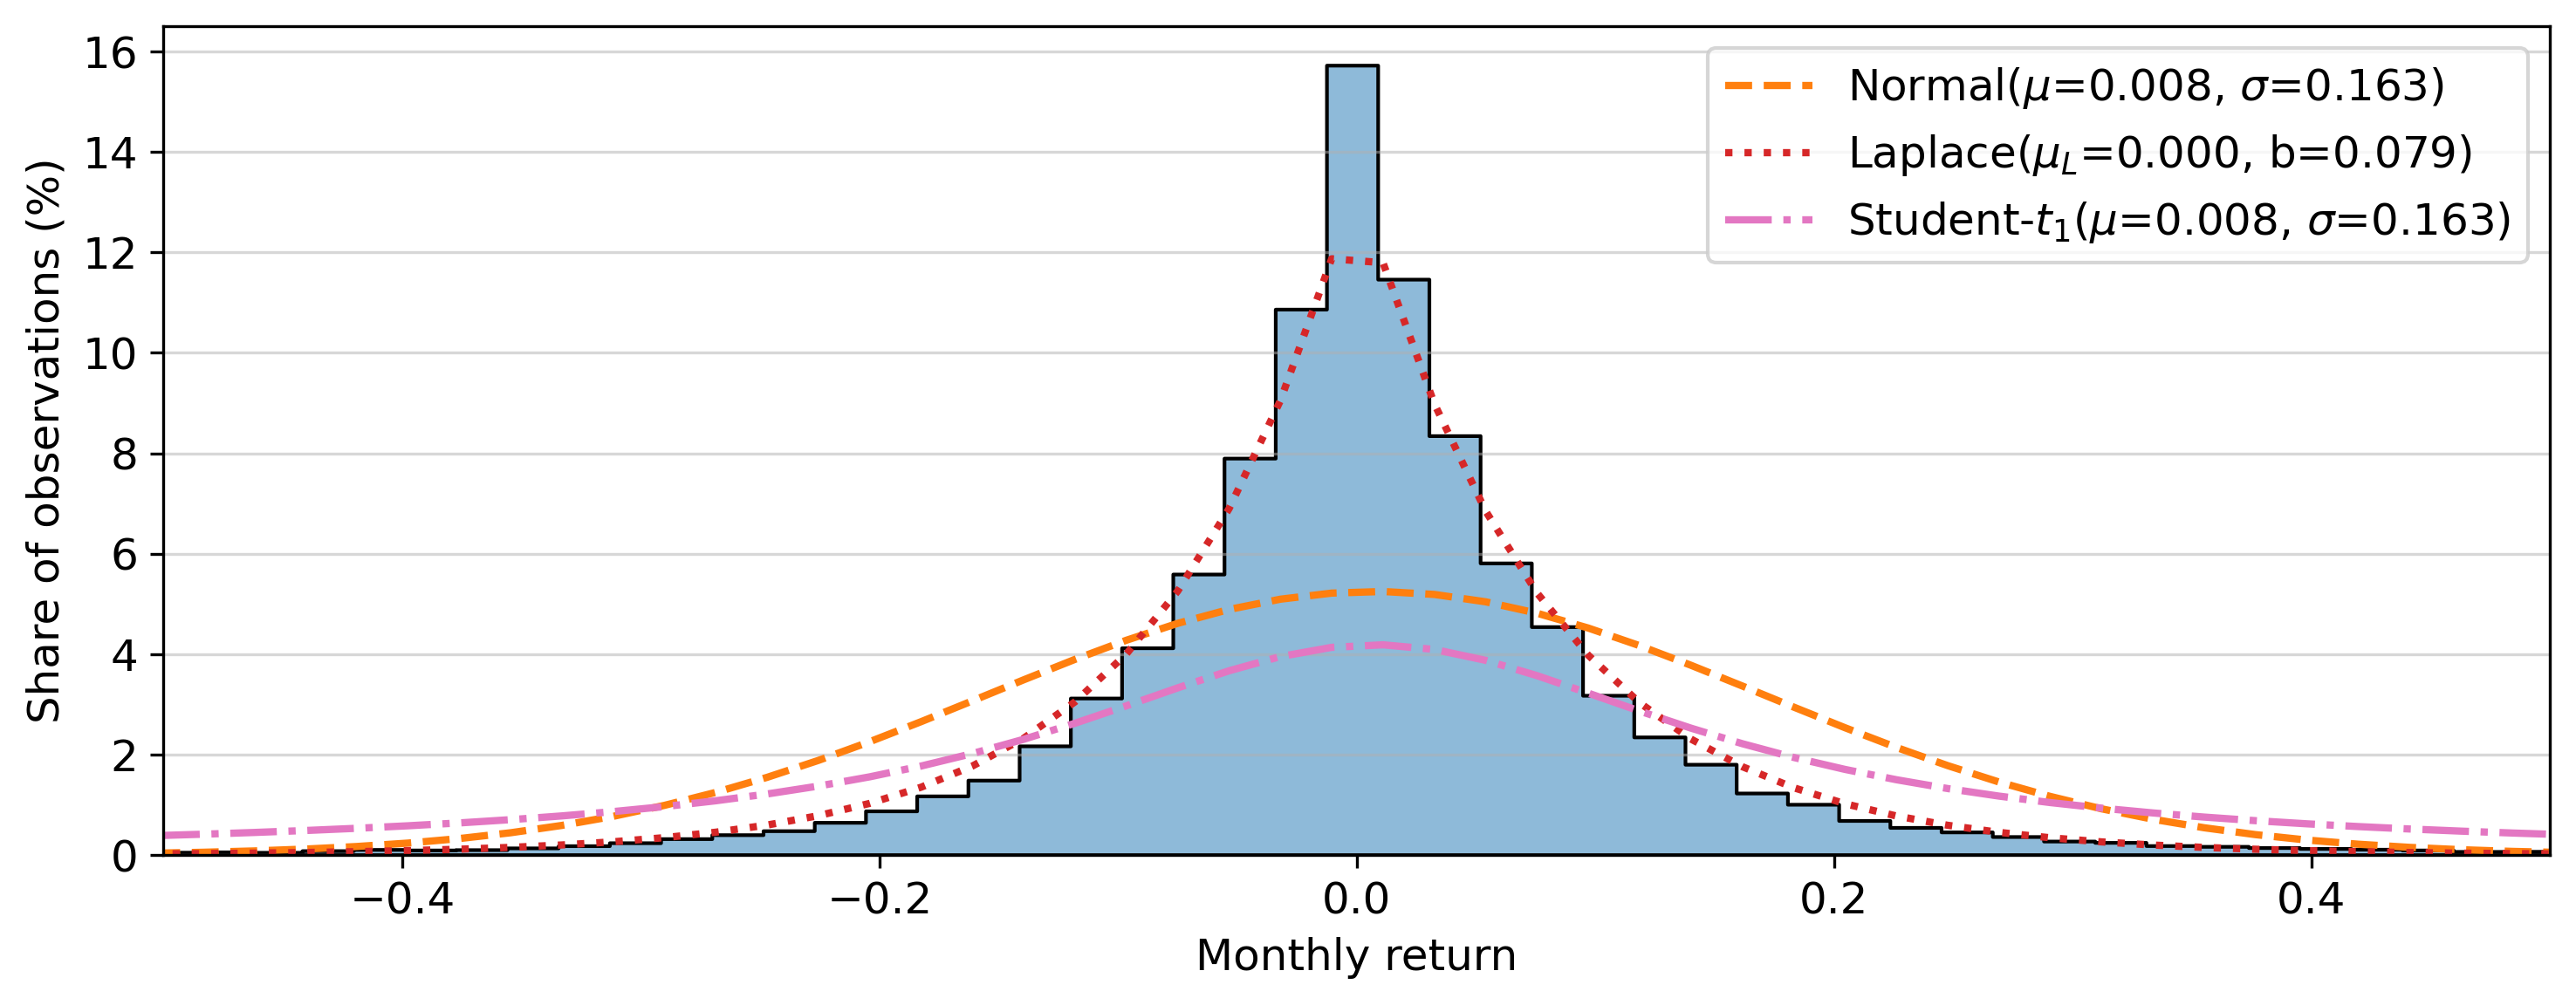

In [18]:
data = df["target"].values

# descriptive stats
mu,    sigma  = data.mean(),  data.std(ddof=0)
mu_lap        = np.median(data)
b_lap         = np.mean(np.abs(data - mu_lap)) # sigma/np.sqrt(2)
nu            = 1                       
bins = 500

# figure
fig, ax = plt.subplots()

# histogram whose bar-tops are *percent*
sns.histplot(
    data,
    bins=bins,
    stat="percent",          
    element="step",
    edgecolor="black",
    color="C0",
    alpha=0.5,
    ax=ax,
)

# x-grid for the pdf curves
x = np.linspace(data.min(), data.max(), bins)
scale = 100 * (x.max() - x.min()) / bins

# overlays
pdf_gauss = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x - mu)/sigma)**2)
ax.plot(x, scale * pdf_gauss, "C1--", lw=2,
        label=rf"Normal($\mu$={mu:.3f}, $\sigma$={sigma:.3f})")

pdf_lap = (1/(2*b_lap)) * np.exp(-np.abs(x - mu_lap)/b_lap)
ax.plot(x, scale * pdf_lap, "C3:", lw=2,
        label=rf"Laplace($\mu_L$={mu_lap:.3f}, b={b_lap:.3f})")

pdf_t = student_t.pdf(x, df=nu, loc=mu, scale=sigma)  # or your helper
ax.plot(x, scale * pdf_t, "C6-.", lw=2,
        label=rf"Student-$t_{{{nu}}}$($\mu$={mu:.3f}, $\sigma$={sigma:.3f})")

ax.set(
    xlabel="Monthly return",
    ylabel="Share of observations (%)",
    xlim=(-0.5, 0.5),
)
ax.legend()
ax.grid(axis="y", alpha=0.5)
fig.tight_layout()
fig.savefig("figs/target_distribution.png", dpi=300)
plt.show()


In [19]:
# create table with 